# Fordgobike Trip Data Exploration
## by Sarah Irungu

## Introduction

The data included in the bike share trip dataset was collected during the month of February 2019. It has more that 170k rows and 16 variables. It includes duration of a trip, start and end time of trips, among other variables.


### Questions:
1. What is the distribution of the duration a trip takes?
2. When are most trips taken in terms of time of day, day of the week?
3. How long does the average trip take?

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
#load dataset
bike_df = pd.read_csv('201902-fordgobike-tripdata.csv')
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               183412 non-null int64
start_time                 183412 non-null object
end_time                   183412 non-null object
start_station_id           183215 non-null float64
start_station_name         183215 non-null object
start_station_latitude     183412 non-null float64
start_station_longitude    183412 non-null float64
end_station_id             183215 non-null float64
end_station_name           183215 non-null object
end_station_latitude       183412 non-null float64
end_station_longitude      183412 non-null float64
bike_id                    183412 non-null int64
user_type                  183412 non-null object
member_birth_year          175147 non-null float64
member_gender              175147 non-null object
bike_share_for_all_trip    183412 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 22.4+ MB


In [3]:
bike_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


## Data Cleaning

In [4]:
#copy of dataset for cleaning purposes
copy_df = bike_df.copy()

Removing null values

In [5]:
copy_df.dropna(inplace=True)
copy_df.reset_index(drop=True, inplace=True)

In [6]:
#remove columns I think wont be helpful during analysis
cols = ['start_station_id', 'start_station_latitude', 'start_station_longitude', 
        'end_station_id', 'end_station_latitude', 'end_station_longitude']
copy_df.drop(cols, axis=1, inplace=True)
copy_df.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_name',
       'end_station_name', 'bike_id', 'user_type', 'member_birth_year',
       'member_gender', 'bike_share_for_all_trip'],
      dtype='object')

In [7]:
#change datatypes of some columns
copy_df['user_type'] = copy_df['user_type'].astype('category')
copy_df['member_birth_year'] = copy_df['member_birth_year'].astype('int')
copy_df['member_gender'] = copy_df['member_gender'].astype('category')
copy_df['bike_share_for_all_trip'] = copy_df['bike_share_for_all_trip'].astype('category')

copy_df['start_time'] = pd.to_datetime(copy_df['start_time'])
copy_df['end_time'] = pd.to_datetime(copy_df['end_time'])

In [8]:
copy_df.member_birth_year.describe()

count    174952.000000
mean       1984.803135
std          10.118731
min        1878.000000
25%        1980.000000
50%        1987.000000
75%        1992.000000
max        2001.000000
Name: member_birth_year, dtype: float64

Since the data is of the yaer 2019, there are some outlier values in the member_birth_year column (min is 1878). I will use a cut off of 85 years i.e. minnmum of 1934


In [9]:
copy_df = copy_df.query('member_birth_year >= 1934')
copy_df.member_birth_year.describe()

count    174765.000000
mean       1984.873390
std           9.881006
min        1934.000000
25%        1980.000000
50%        1987.000000
75%        1992.000000
max        2001.000000
Name: member_birth_year, dtype: float64

In [10]:
# intervals of the birth year column
bins = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# pd.cut to create the member_birth_year category column(birth_grp_year)
copy_df['birth_grp_year'] = pd.cut(copy_df['member_birth_year'], 
                                   bins=bins, labels=['1930-1939', '1940-1949', '1950-1959', '1960-1969', 
                                                      '1970-1979', '1980-1989', '1990-1999', '2000-2010'])
copy_df.birth_grp_year.head()

0    1980-1989
1    1970-1979
2    1980-1989
3    1970-1979
4    1950-1959
Name: birth_grp_year, dtype: category
Categories (8, object): [1930-1939 < 1940-1949 < 1950-1959 < 1960-1969 < 1970-1979 < 1980-1989 < 1990-1999 < 2000-2010]

In [11]:
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174765 entries, 0 to 174951
Data columns (total 11 columns):
duration_sec               174765 non-null int64
start_time                 174765 non-null datetime64[ns]
end_time                   174765 non-null datetime64[ns]
start_station_name         174765 non-null object
end_station_name           174765 non-null object
bike_id                    174765 non-null int64
user_type                  174765 non-null category
member_birth_year          174765 non-null int64
member_gender              174765 non-null category
bike_share_for_all_trip    174765 non-null category
birth_grp_year             174765 non-null category
dtypes: category(4), datetime64[ns](2), int64(3), object(2)
memory usage: 11.3+ MB


In [12]:
copy_df.start_time.sample(6)

21940    2019-02-26 06:49:26.809
146701   2019-02-06 11:21:27.208
137266   2019-02-07 13:54:43.850
139689   2019-02-07 08:44:18.302
74912    2019-02-18 20:13:13.360
94642    2019-02-14 20:38:02.666
Name: start_time, dtype: datetime64[ns]

In [13]:
# day of week and hour columns
copy_df['day_of_week'] = copy_df.start_time.apply(lambda x: x.strftime('%A'))
copy_df['hour_of_day'] = copy_df.start_time.dt.hour

copy_df.head(2)

,duration_sec,start_time,end_time,start_station_name,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,birth_grp_year,day_of_week,hour_of_day
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,Montgomery St BART Station (Market St at 2nd St),Commercial St at Montgomery St,4902,Customer,1984,Male,No,1980-1989,Thursday,17
1,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,Market St at Dolores St,Powell St BART Station (Market St at 4th St),5905,Customer,1972,Male,No,1970-1979,Thursday,12


In [14]:
#save our clean dataset
copy_df.to_csv('201902-fordgobike-tripdata_clean.csv')

### What is the structure of your dataset?
- There are 183412 rows and 16 columns.
- Datatypes are number(int and float), string(object).
- We also have categorical variables - user_type, member_gender

### What is/are the main feature(s) of interest in your dataset?
- The main feature of interest will be the duration_sec, which is the duration a single trip takes to complete.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
- user_type, member_birth_year, member_gender


## Univariate Exploration


In [15]:
# ploting function
def plot(data, graph_type, x, xlabel, ylabel, title, y=None, binsize=500, figsize=[8,5], legend=None):
    '''A function that takes parameters of the plotting functions 
    plots different graphs as given in the parameters using matplotlib'''
    
    binsize = binsize
    bins = np.arange(0, data[x].max()+binsize, binsize)
    plt.figure(figsize=figsize)
    if graph_type == 'hist':
        plt.hist(data=data, x=x, bins=bins)
    elif graph_type == 'errorbar':
        plt.errorbar(data=data, x=x, y=y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()   

In [16]:
#base color of seaborn plots
base_color = sb.color_palette()[0]

#seaborn plotting functions
def sb_plot(graph_type, title, x=None, y=None, data=copy_df,
            figsize=[8, 5], legend=None, color=None, order=None, hue=None):
    '''A function that takes parameters of the plotting functions 
    plots different graphs as given in the parameters using seaborn'''
    
    plt.figure(figsize=figsize)
    if graph_type == 'countplot':
        sb.countplot(data=data, x=x, y=y, color=color, order=order, hue=hue)
    elif graph_type == 'violinplot':
        sb.violinplot(data=data, x=x, y=y, hue=hue, order=order)
    elif graph_type == 'pointplot':
        sb.pointplot(data=data, x=x, y=y, hue=hue, dodge=0.3, linestyles='', order=order)
    plt.title(title)
    plt.show()
    

### Q1. What is the distribution of the duration a trip takes?
### duration_sec

In [17]:
#summary stats of the duration_sec column
copy_df['duration_sec'].describe()

count    174765.000000
mean        704.302841
std        1643.009039
min          61.000000
25%         323.000000
50%         511.000000
75%         789.000000
max       84548.000000
Name: duration_sec, dtype: float64

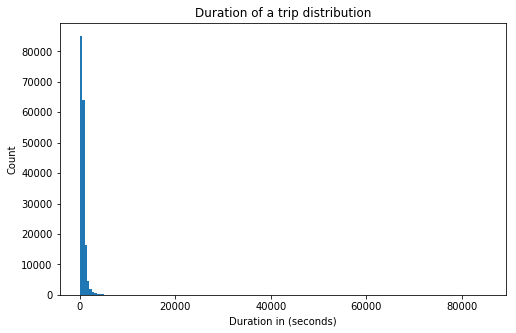

In [18]:
#plotting using default bin size of 500
plot(copy_df, 'hist', 'duration_sec', 'Duration in (seconds)', 'Count', 'Duration of a trip distribution')

> We can see that the plot has many hidden counts so I will plot using log scale

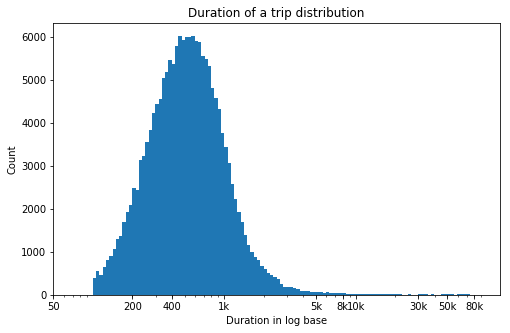

In [19]:
#plotting duration_sec in log base
binsize = 0.025
bins = 10 ** np.arange(2, np.log10(copy_df['duration_sec'].max())+binsize, binsize)
plt.figure(figsize=[8,5])
plt.hist(data=copy_df, x='duration_sec', bins=bins)
plt.title('Duration of a trip distribution')
plt.xscale('log')
plt.xticks([50, 200, 400, 1e3, 5e3, 8e3, 1e4, 3e4, 5e4, 8e4], 
            ['50', '200', '400', '1k', '5k', '8k', '10k', '30k', '50k', '80k'])
plt.xlabel('Duration in log base')
plt.ylabel('Count')
plt.show()

> We can now see that many trips take between 200 and 1k seconds, with the peak being around 400 to 800 seconds

### How long does the average trip take?

In [20]:
copy_df['duration_sec'].mean()

704.30284095785771

> An average trip takes about 704 seconds.

### Distribution of other variables
### user_type

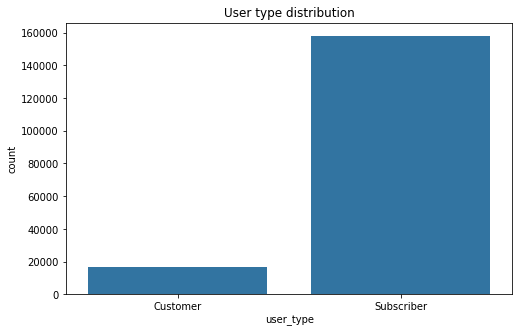

In [21]:
#plot the user_type counts
sb_plot('countplot', 'User type distribution', x='user_type', color=base_color)

> Majority of users have a subscription

### member_gender

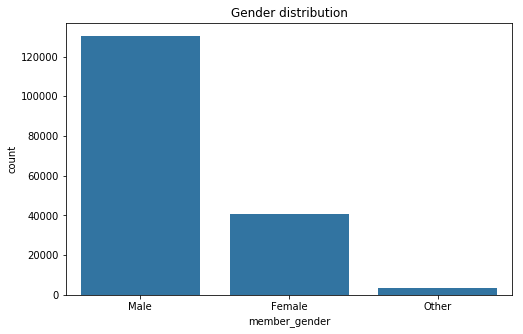

In [22]:
#compute frequency of gender
frequency = copy_df.member_gender.value_counts()
#get index in descending order for display purposes
gender_order = frequency.index
sb_plot('countplot', 'Gender distribution', x='member_gender', color=base_color, order=gender_order)

> Men are the highest bike share users.

### birth_grp_year

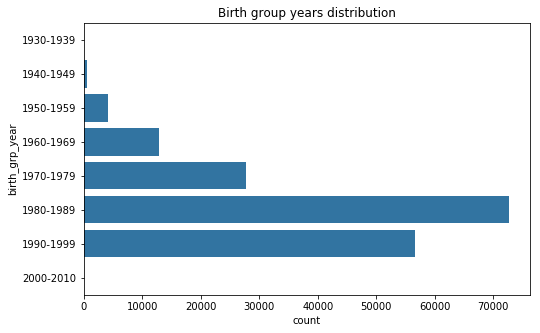

In [23]:

sb_plot('countplot', 'Birth group years distribution', y='birth_grp_year', color=base_color)

> People between the birth year of 1980 to 1999 are the majority of bike users.

### bike_share_for_all_trip

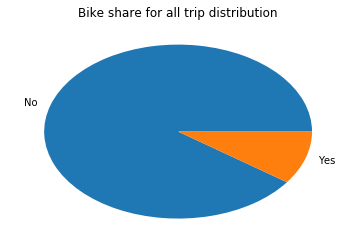

In [24]:
#calculate frequency and reset index
labels = copy_df.bike_share_for_all_trip.value_counts().reset_index()
#rename column names
labels.columns = ['bike_share_for_all_trip', 'count']
#plot a pie chart
plt.pie(labels['count'], labels=labels.bike_share_for_all_trip);
plt.title('Bike share for all trip distribution');

> We see that many users did not use bike share for the whole trips.

### When are most trips taken in terms of time of day, day of the week?
### day_of_week

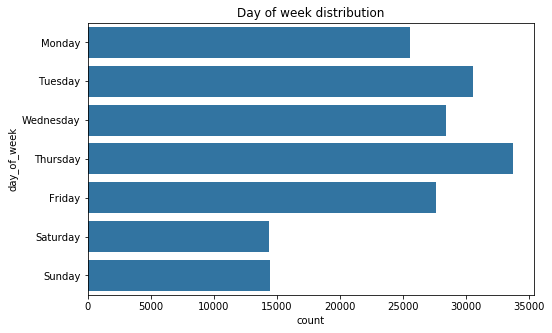

In [25]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sb_plot('countplot', 'Day of week distribution', y='day_of_week', color=base_color, order=day_order)


> Most trips are taken on Thursdays and tuesdays and the least being on Saturdays and sundays

### hour_of_day

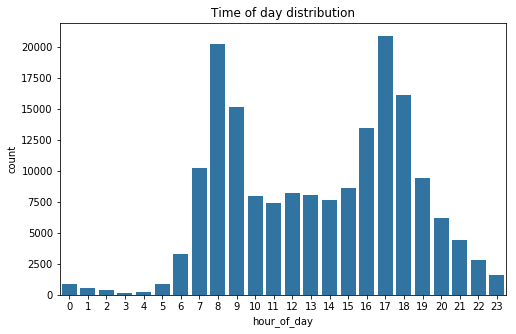

In [26]:
sb_plot('countplot', 'Time of day distribution', x='hour_of_day', color=base_color)

> A normal distribution is observed with peaks being from 7 to 9hours (7 to 9 a.m.) and 16 to 18 hours(4 to 6 p.m.)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

- The variable of interest, duration_sec, is normally distributed with many trips taking between 50 seconds to 1k seconds. I performed log scale plotting to get a better picture of the distribution.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

- The member_birth_year had some outliers, e.g. 1878, I chose a cut off of 85 years or the year 1934.
- I made a category column(birth_grp_year) for the member_birth_year column to make ploting and visualization easier.
- For the time column, I added hour_of_day and day_of_week columns so that I could easily visualize the distribution of bike share counts in terms of hour and day of week.

## Bivariate Exploration

### member_birth_year vs duration_sec

In [27]:
# mean duration seconds of year
duration_mean = copy_df.groupby('member_birth_year')['duration_sec'].mean()
duration_mean = duration_mean.reset_index()
duration_mean.head(2)

,member_birth_year,duration_sec
0,1934,378.5
1,1938,526.0


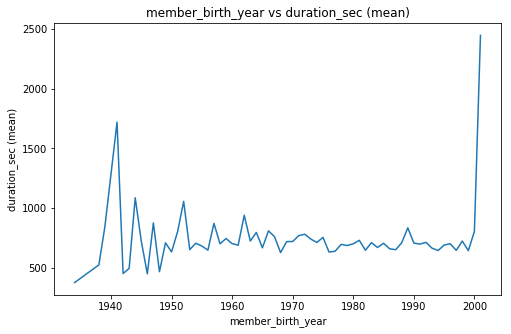

In [28]:
plot(duration_mean, 'errorbar', 'member_birth_year', 'member_birth_year', 
     'duration_sec (mean)', 'member_birth_year vs duration_sec (mean)', y='duration_sec')

> The duration time means are between 500 and 1000 seconds with peaks between 1500 and 2500.

### hour_of_day vs duration_sec

In [29]:
# grouping the df by hour of day and calculating the mean of duration secs
duration_mean = copy_df.groupby('hour_of_day')['duration_sec'].mean()
duration_mean = duration_mean.reset_index()
duration_mean.head(2)

,hour_of_day,duration_sec
0,0,809.253363
1,1,652.451429


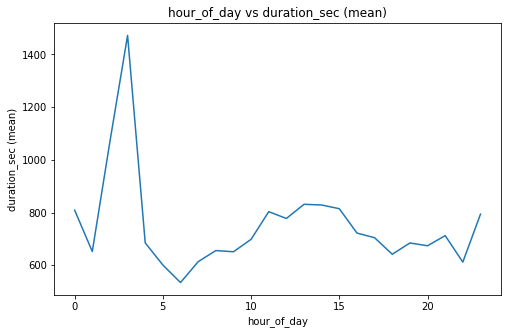

In [30]:
plot(duration_mean, 'errorbar', 'hour_of_day', 'hour_of_day', 
     'duration_sec (mean)', 'hour_of_day vs duration_sec (mean)', y='duration_sec')

> We can see that the duration time average is highest between 0 hours (midnight) and 5 (5 a.m.)

### member_gender vs user_type
2 qualitative variables

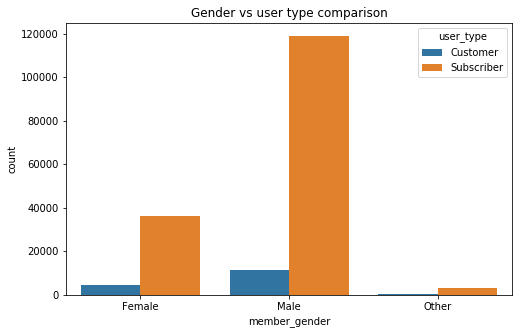

In [31]:
sb_plot('countplot', 'Gender vs user type comparison', x='member_gender', hue='user_type')

> It doesnt matter whether male or female, we see that subscribers are more bike share users than just normal customers.

### day_of_week vs hour_of_day

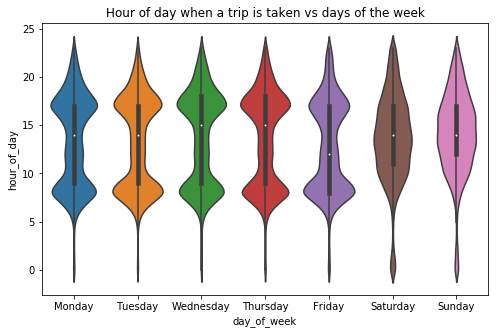

In [32]:
sb_plot('violinplot', 'Hour of day when a trip is taken vs days of the week',
        x='day_of_week', y='hour_of_day', order=day_order)

> For weekdays peak hours are between 5 a.m to 10 a.m and 3 p.m to 8 p.m for weekends its between  10 a.m and 3 p.m.

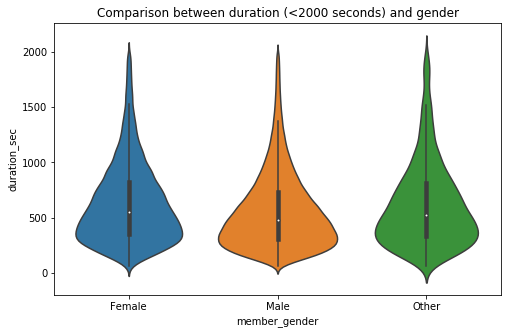

In [33]:
# a slice of the data with duration of less than 2000 seconds
slice = copy_df.query('duration_sec < 2000')
sb_plot('violinplot', 'Comparison between duration (<2000 seconds) and gender', data=slice,
        x='member_gender', y='duration_sec')
#slice.shape

> Irregardless of gender, common trip duration is slightly below 500 seconds.

### day_of_week vs duration

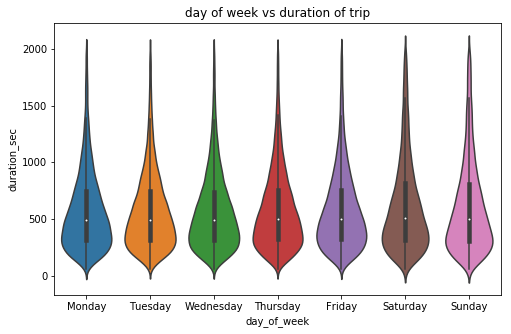

In [34]:
sb_plot('violinplot', 'day of week vs duration of trip', data=slice, x='day_of_week', y='duration_sec', order=day_order)

> Most trips take less than 500 seconds all through the week.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

- For duration vs day_of_week and duration vs gender, the duration of most trips is below 500 seconds. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

- Subscribers tended to use bikes more than customers, in terms of gender and user type.
- The peak bike usage hours on weekdays fall between 5 a.m and 10 a.m and 3 p.m to 8 p.m, whereas on weekends they occur between 10 a.m and 3 p.m., based on the day of the week and the hour of the day.

## Multivariate Exploration


### day_of_week vs duration_sec vs user_type

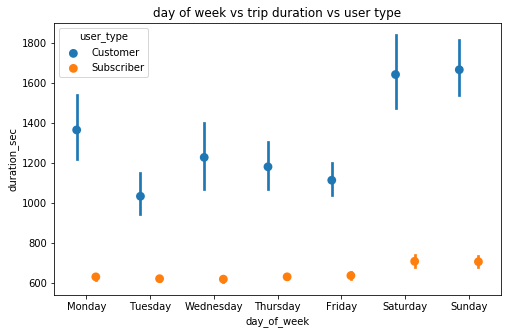

In [35]:
sb_plot('pointplot', 'day of week vs trip duration vs user type', x='day_of_week', 
        y='duration_sec', hue='user_type', order=day_order)

> subscribers take less time compared to customers

### day_of_week vs duration_sec vs member_gender

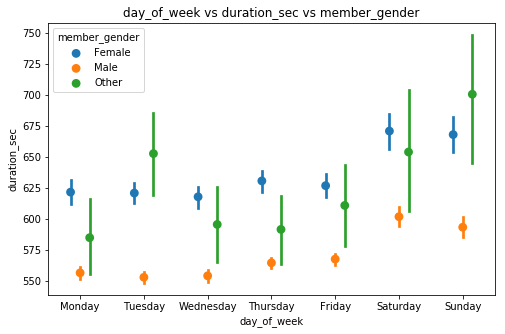

In [36]:
sb_plot('pointplot', 'day_of_week vs duration_sec vs member_gender', data=slice,
        x='day_of_week', y='duration_sec', hue='member_gender', order=day_order)

> Overall males take less time, with this trend being pronounced on Wednesday and Tuesday as they have the shortest trip duration

### user_type vs duration_sec vs member_gender

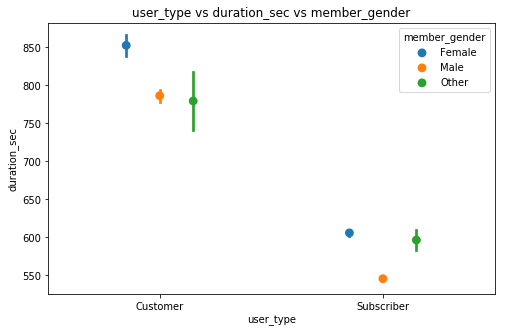

In [37]:
sb_plot('pointplot', 'user_type vs duration_sec vs member_gender', data=slice, x='user_type', y='duration_sec', hue='member_gender')

> Male subscribers take less trip time.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

- Subscribers tend to take shorter trips than customers, male subscribers take even shorter trips than female and others.


### Were there any interesting or surprising interactions between features?

- The most popular time for bike share trips is during weekday rush hours, with a secondary peak on weekends during midday hours.

## Conclusions
The trip duration has a normal unimodal distribution. Subscribers take less trip duration compared to customers. The highest average duration of trips is between midnight and 5 a.m. 

Majority of bike users are aged between 20 and 39 years i.e. birth year range of 1989 to 1999. On weekdays  bike usage is at peak between 5 a.m and 10 a.m and 3 p.m to 8 p.m and on weekends the peak is between 10 a.m and 3 p.m.
